In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import sys
sys.path.append("../../")

In [3]:
# Check Data 
datafile = pd.read_csv("artifacts/dataset:v2/dataset.csv.gz")
datafile.head()

,Unnamed: 0,chrom,seq,hepg2,k562,sknsh
0,0,chr7,CCTGGTCTTTCTTGCTAAATAAACATATCGTGCATCATCCAGATCT...,0.233601,0.060779,0.047194
1,1,chr1,CATAAAGATGAGGCTTGGCAAAGAACATCTCTCGGTGCCTCCCATT...,0.004565,0.379639,-0.244395
2,2,chr1,CATAAAGCCAATCACTGAGATGACAAGTACTGCCAGGAAAGAAGGC...,0.384537,0.036707,-0.004578
3,3,chr15,CATAAAGGCAGTGTAGACCCAAACAGTGAGCAGTAGCAAGATTTAT...,4.116494,4.508784,3.040183
4,4,chr12,CATAAAGGGCTGAACATGCTGTTGAAAAAATGTAGATATAAAAGTT...,1.423444,1.616602,1.335892


In [4]:
# Select data 
small_data = datafile.loc[ (datafile['chrom'] =="chr1") | (datafile['chrom'] =="chr2") |(datafile['chrom'] =="chr3") |(datafile['chrom'] =="chr4")  ]

In [5]:
from src.utils.sequence import seqs_to_one_hot

seq_x = [seqs_to_one_hot(seq)[:, 0, :] for seq in small_data['seq']]
small_data_x = np.array(seq_x)
print(small_data_x.shape) # Data Size 

(203842, 200, 4)


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 3.000e+00,
        1.000e+00, 2.000e+00, 2.000e+0

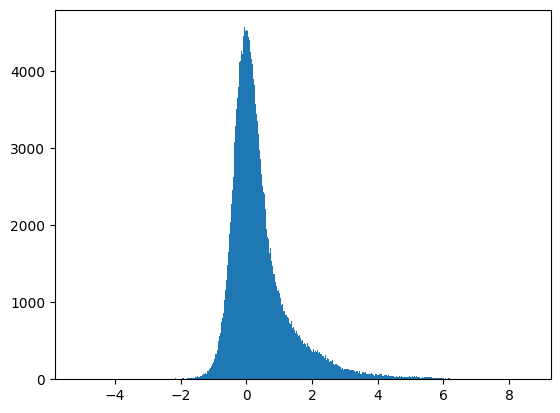

In [6]:
hepg2_scores = np.array(small_data['hepg2'])

import matplotlib.pyplot as plt
plt.hist(hepg2_scores, bins = 'auto')

In [7]:
from grelu.lightning import LightningModel
DEVICE = "cuda:1"

model = LightningModel.load_from_checkpoint("artifacts/model:v4/model.ckpt")
model.eval()
model.to(DEVICE)

/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sarosavo. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


LightningModel(
  (model): EnformerPretrainedModel(
    (embedding): EnformerTrunk(
      (conv_tower): EnformerConvTower(
        (blocks): ModuleList(
          (0): Sequential(
            (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=same)
            (1): ConvBlock(
              (norm): Norm(
                (layer): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (conv): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
              (act): Activation(
                (layer): GELU()
              )
              (pool): Pool(
                (layer): AttentionPool(
                  (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
                  (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
              )
              (dropout): Dropout(
                (layer): Identity()
              )
              (channel_transform): ChannelT

In [8]:
import torch

data_loader = torch.utils.data.DataLoader(small_data_x.astype("float32"), batch_size = 128 , num_workers=0)
relabel_y = []

for batch in data_loader:
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    relabel_y.append( model(batch).detach().cpu() ) 

relabel_y = np.concatenate(relabel_y)

In [9]:
hepg2_relabel_y = relabel_y[:,0].reshape(-1)
k562_relabel_y = relabel_y[:,1].reshape(-1)

print(hepg2_relabel_y.shape)

(203842,)


(array([1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 5.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 4.000e+00,
        6.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 3.000e+0

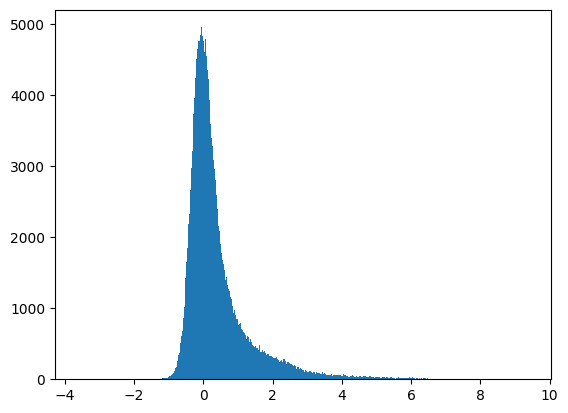

In [10]:
plt.hist(hepg2_relabel_y, bins = 'auto')

(array([1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 6.000e+00,
        5.000e+00, 3.000e+00, 1.000e+00, 4.000e+00, 8.000e+00, 2.000e+00,
        5.000e+00, 1.100e+01, 4.000e+00, 6.000e+00, 1.500e+01, 1.000e+01,
        8.000e+00, 1.000e+01, 2.200e+01, 1.700e+01, 2.800e+01, 3.500e+01,
        3.300e+01, 4.800e+01, 7.100e+01, 1.050e+02, 1.090e+02, 1.610e+02,
        1.810e+02, 2.230e+02, 2.790e+02, 3.500e+02, 4.320e+02, 5.200e+02,
        6.840e+02, 8.150e+02, 9.640e+02, 1.115e+03, 1.407e+03, 1.616e+03,
        1.881e+03, 2.176e+03, 2.494e+0

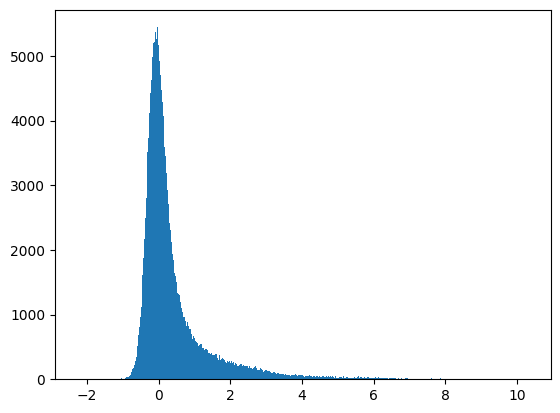

In [11]:
plt.hist(k562_relabel_y, bins = 'auto')

# Save offline data for training

In [12]:
np.savez_compressed("./artifacts/MPRA-dataset:v2/y_HepG2_relabel.npz", x = small_data_x, y = hepg2_relabel_y)